<a href="https://colab.research.google.com/github/silent-ai/chessboard/blob/main/nbs/chessboard_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
! pip install fastai --upgrade > /dev/null

     |████████████████████████████████| 194kB 13.2MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 


In [2]:
from fastai.vision.all import *

## Download data from github

In [3]:
from zipfile import ZipFile as unzip
path = Path('data')

with unzip(download_data('https://tinyurl.com/silentai'), 'r') as ref:
    ref.extractall(path)

In [15]:
with unzip(download_data('https://github.com/silent-ai/chessboard/blob/main/data/chessboard_images.zip?raw=true'), 'r') as ref:
    ref.extractall(path)

In [18]:
imgs = get_image_files(path/'content/chessboard/data/chessboard_images')
#PILImage.create(imgs[0]).RatioResize(size=400)

AttributeError: ignored

## Get annotations

In [5]:
import json
with open(path/'annotations'/'instances_default.json') as f:
  codes = json.load(f)

In [6]:
# Join the images to their label by id
img = {img['id']: img['file_name'] for img in codes['images']}
ann = {img['id']: img['segmentation'][0] for img in codes['annotations']}
labels = {img[id]: list(zip(a[::2], a[1::2])) for id, a in ann.items()}

# Grab the first example
first(labels.items())

('frame880.jpg',
 [(121.17, 384.51), (658.68, 500.22), (505.64, 910.82), (42.78, 845.5)])

In [7]:
def get_label(f): return tensor(labels[f.name])

In [8]:
get_label(path/'images'/'frame80.jpg')

tensor([[117.4400, 536.5900],
        [542.0300, 421.5000],
        [720.0000, 804.1000],
        [226.3100, 973.6200]])

## Datablock API

In [9]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_label,
    #item_tfms=Resize(320),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)


SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.03981071710586548)

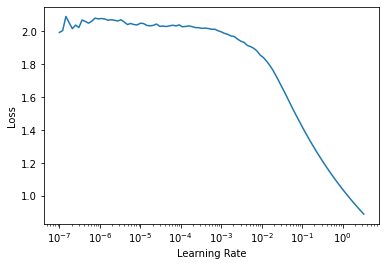

In [41]:
#imgs = get_image_files(path/'content/chessboard/data/chessboard_images')
#def overwriter(fname): return 'chessboard'
#lambda is like def but anonomous 
chess = DataBlock(
    #TensorCategory(0) is type for Category
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    
    #get image file output passed into overwriter call
    #ML: x is input, y is label
    get_y=lambda x: 'chessboard',
    
    #specify validation set
    splitter=RandomSplitter(),

    #specify item transformations
    item_tfms=Resize(size=224)
)
chessboard_dls = chess.dataloaders(path/'content')
#chessboard_dls.show_batch()

chesslearn = cnn_learner(chessboard_dls, resnet34, n_out=3)
#n out is number of categories out 
#res34 is arch which has been pretrained already so has classifications like man, dog, frog

chesslearn.lr_find()


In [19]:
dls = biwi.dataloaders(path/'content', bs=4)
dls.show_batch(max_n=9, figsize=(8,6))

KeyError: ignored

## Train

In [11]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=1.3182567499825382e-06)

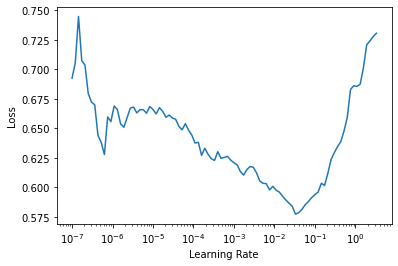

In [12]:
learn.lr_find()

In [13]:
learn.fine_tune(3, 5e-2)

epoch,train_loss,valid_loss,time
0,0.741441,0.911932,00:03


epoch,train_loss,valid_loss,time
0,0.720927,1.272618,00:03
1,0.774735,1.149863,00:02
2,0.767750,0.920821,00:02


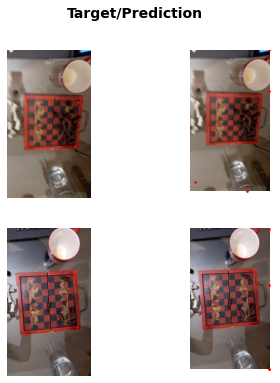

In [14]:
learn.show_results()